## Fit Machine Learning Models
- Train and Test Models using a Variety of Appropriate [Classification] Algorithms
- Tune (Optimize) Each Model''s Hyperparameters
- Evaluate the Optimally-Fitted Models Against a Hold-Out (Out-of-Sample) Dataset
- Perform K-Fold Cross-Validation Using Each Model
- Determine Each Model''s Accuracy and Identify the Best Model.

### Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd

import sklearn
print("SciKit-Learn Version:", sklearn.__version__)

if sklearn.__version__ >= '0.18.0':  # Starting with sklearn version 18.0
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
else:
    from sklearn.cross_validation import train_test_split, cross_val_score
    from sklearn.cross_validation import GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

SciKit-Learn Version: 0.19.1


### Define Globals

In [2]:
hold_out_percent = 0.2
CLASSIFICATION_TYPE = 'Binary'

###################################################################################################################
# Calculate the Null Accuracy Score: Accommodates Binary or Multiple Classification Type
###################################################################################################################
def null_accuracy_score(labels, classification_type):  #NOTE: 'labels' must be a pd.Series
    if classification_type == CLASSIFICATION_TYPE:
        return max(labels[:,].astype(int).mean(), 1 - labels[:,].astype(int).mean())
    
    elif classification_type == CLASSIFICATION_TYPE:
        return labels.value_counts().head(1).item() / len(labels) 
    
    else:
        raise ValueError("Bad input {0}. Must specify either 'Binary' or 'Multiple'.".format(classification_type))
        

##################################################################################################################
# Print Evaluation Metrics: Accuracy and Null Accuracy Scores
###################################################################################################################
def show_accuracy(y_actuals, y_predictions, classification_type):
    accuracy = accuracy_score(y_actuals, y_predictions)
    null_accuracy = null_accuracy_score(y_actuals, classification_type)

    print('----------------------------------------------------------------------------------')
    print('Accuracy (The Percentage of Correct Predictions): %0.3f' % accuracy)
    print('----------------------------------------------------------------------------------')
    print('Null Accuracy (Achieved by Always Predicting the Most Frequent Class): %0.3f' % null_accuracy)
    print('----------------------------------------------------------------------------------')   
    print('True:', list(y_actuals[0:10]))
    print('Pred:', y_predictions[0:10].tolist())
    print('----------------------------------------------------------------------------------\n')
        

##################################################################################################################
# Print Skree Plots: Compare the Explained Variances per Component Between Train/Test and Hold-Out Datasets
###################################################################################################################
def show_skree_plots(components, variances_explained):
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(7, 7))
    
    ax0.set_title("PCA Explained Variances: Train/Test Data")
    ax0.scatter(components, variances_explained[0])
    ax0.set_ylabel('Explained Variance (Eigenvalues)')
    ax0.grid(True)

    ax1.set_title("PCA Explained Variances: Hold-Out Data")
    ax1.scatter(components, variances_explained[1])
    ax1.set_ylabel('Explained Variance (Eigenvalues)')
    ax1.set_xlabel('Number of Components (Eigenvectors)')
    ax1.grid(True)

    plt.tight_layout()
    plt.show()
        

###################################################################################################################
# Print a Confusion Matrix:  Accommodates Binary or Multiple Classification Type
###################################################################################################################
def show_confusion_matrix(y_actuals, y_predictions, y_probabilities, classification_type):
    print('-------------------------------------------------------')
    print('Confusion Matrix')
    print('-------------------------------------------------------')

    cm = pd.crosstab(y_actuals, y_predictions, rownames=['Actuals'], colnames=['Predictions'])
    print(cm)
        
    if classification_type == CLASSIFICATION_TYPE:
        print('-------------------------------------------------------')
        print('Area Under the Curve (AUC): %0.3f' % roc_auc_score(y_actuals, y_probabilities[:, 1]))
        
    print('-------------------------------------------------------\n')
    
    
###################################################################################################################
# Print a Classification Report
###################################################################################################################
def show_classification_report(y_actuals, y_predictions):
    print('-------------------------------------------------------')
    print('Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_actuals, y_predictions))
    print('-------------------------------------------------------\n')
    

###################################################################################################################
# Print a Receiver Operating Characteristic (ROC) Curve Plot (Binary Classification Only).
###################################################################################################################
def show_roc_plot(y_actuals, y_probabilities, classifier_algorithm):
    plt.figure(figsize=(5,5))
    plt.title('ROC Curve (' + classifier_algorithm + ')')

    fpr, tpr, _ = roc_curve(y_actuals, y_probabilities[:, 1])
    auc = roc_auc_score(y_actuals, y_probabilities[:, 1])

    plt.plot(fpr, tpr, color='darkorange', label='ROC Curve (area = %0.2f)' % auc)
    plt.plot([0,1], [0,1], color='steelblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

### Load Data

In [3]:
# Locate the Data File to be Ingested.
data_dir = os.path.join(os.getcwd(), 'Data')
source_file = os.path.join(data_dir, 'WA-Telco-Customer-Churn-ML.xlsx')

# Read the Data from the Source File
df = pd.read_excel(source_file, header=0)

# Display the Dimensions of the DataSet Being Used.
print("DataSet Dimensions:", df.shape)

DataSet Dimensions: (7043, 21)


#### Make Appropriate Data Type Assignments.

In [4]:
df.gender = df.gender.astype('category')
df.SeniorCitizen = df.SeniorCitizen.astype('category')
df.Partner = df.Partner.astype('category')
df.Dependents = df.Dependents.astype('category')
df.tenure = pd.to_numeric(df.tenure, downcast='integer', errors='coerce')
df.PhoneService = df.PhoneService.astype('category')
df.MultipleLines = df.MultipleLines.astype('category')
df.InternetService = df.InternetService.astype('category')
df.OnlineSecurity = df.OnlineSecurity.astype('category')
df.OnlineBackup = df.OnlineBackup.astype('category')
df.DeviceProtection = df.DeviceProtection.astype('category')
df.TechSupport = df.TechSupport.astype('category')
df.StreamingTV = df.StreamingTV.astype('category')
df.StreamingMovies = df.StreamingMovies.astype('category')
df.Contract = df.Contract.astype('category')
df.PaperlessBilling = df.PaperlessBilling.astype('category')
df.PaymentMethod = df.PaymentMethod.astype('category')
df.MonthlyCharges = pd.to_numeric(df.MonthlyCharges, downcast='float', errors='coerce')
df.TotalCharges = pd.to_numeric(df.TotalCharges, downcast='float', errors='coerce')
df.Churn = df.Churn.astype('category')
df.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                  int8
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float32
TotalCharges         float32
Churn               category
dtype: object

#### Separate the Predictors from the Response.

In [5]:
# Separate the Dependant Variable (Target, Response, Label) from the Independant Variables (Predictor).
X = df.drop(labels=['customerID', 'Churn'], axis=1)
y = df.Churn

#### Create a Hold-Out Data Set for Model Evaluation

In [6]:
# Divide into Train/Test and Evaluation (Hold-Out) Sets.
X, X_eval, y, y_eval = train_test_split(X, y, test_size = hold_out_percent, random_state=42)

# Use 80% of the observations for training and testing...
print('-------------------------------------------------------------------')
print("Train/Test Observations:", X.shape)

# ...And hod out the rest for final evaluation.
print("Evaluation Observations:", X_eval.shape)
print('-------------------------------------------------------------------\n')

# Examine the distribution of Labels for the two datasets.
print("Train/Test Label Distribution:\n", y.value_counts())
print('-------------------------------------------------------------------')
print("Evaluation Label Distribution:\n", y_eval.value_counts())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Train/Test Observations: (5634, 19)
Evaluation Observations: (1409, 19)
-------------------------------------------------------------------

Train/Test Label Distribution:
 0    4138
1    1496
Name: Churn, dtype: int64
-------------------------------------------------------------------
Evaluation Label Distribution:
 0    1036
1     373
Name: Churn, dtype: int64
-------------------------------------------------------------------


#### Create Training and Testing Datasets 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 60% of the observations for training...
print('-------------------------------------------------------------------')
print("Training Observations:", X_train.shape)

# ...And use the rest for testing.
print("Testing Observations:", X_test.shape)
print('-------------------------------------------------------------------\n')

# Examine the distribution of Labels for the two datasets.
print("Training Label Distribution:\n", y_train.value_counts())
print('-------------------------------------------------------------------')
print("Testing Label Distribution:\n", y_test.value_counts())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Training Observations: (4507, 19)
Testing Observations: (1127, 19)
-------------------------------------------------------------------

Training Label Distribution:
 0    3316
1    1191
Name: Churn, dtype: int64
-------------------------------------------------------------------
Testing Label Distribution:
 0    822
1    305
Name: Churn, dtype: int64
-------------------------------------------------------------------


#### Perform Scalar Normalization of Each Dataset.

In [8]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X = sc.fit_transform(X)
X_eval = sc.transform(X_eval)

### Use Principal Component Analysis (PCA) for Parameter Reduction

In [9]:
# Define the Number of Components to Target
n_components = 18

# Instantiate a List to Hold Collections of PCA Explained Variances.
variances = []

##### Perform PCA Feature Reduction on the Train/Test Data

In [10]:
%%time

pca = PCA(n_components=n_components)

# Reduce the data, outputting an ndarray
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Get the explained variance associated with each component.
explained_variance = pca.explained_variance_ratio_

# Append the explained variances to the Variances List.
variances.append(explained_variance)

# Print out the explained variance associated with each component.
print(explained_variance)
print('-------------------------------------------------------------------')
print("Total Variance Explained: %0.4f" % sum(explained_variance))
print('-------------------------------------------------------------------')

[0.22109351 0.12178083 0.07855374 0.06439829 0.05586759 0.05281484
 0.04937758 0.04587222 0.04240616 0.04123619 0.03776866 0.03702492
 0.03675305 0.02998517 0.02966082 0.02514756 0.01701584 0.01041839]
-------------------------------------------------------------------
Total Variance Explained: 0.9972
-------------------------------------------------------------------
Wall time: 201 ms


##### Perform PCA Parameter Reduction on the Hold-Out Data

In [11]:
%%time

pca_holdout = PCA(n_components=n_components)

# Reduce the data, outputting an ndarray
X = pca_holdout.fit_transform(X)
X_eval = pca_holdout.transform(X_eval)

# Get the explained variance associated with each component.
explained_variance_holdout = pca_holdout.explained_variance_ratio_

# Append the explained variances to the Variances List.
variances.append(explained_variance_holdout)

# Print out the explained variance associated with each component.
print(explained_variance_holdout)
print('-------------------------------------------------------------------')
print("Total Variance Explained: %0.4f" % sum(explained_variance_holdout))
print('-------------------------------------------------------------------')

[0.22268568 0.12169782 0.07852919 0.06392973 0.05598127 0.05278273
 0.04972987 0.0459601  0.04251888 0.04090496 0.03763186 0.03678124
 0.03643007 0.03020616 0.02957181 0.02465513 0.01688429 0.01031678]
-------------------------------------------------------------------
Total Variance Explained: 0.9972
-------------------------------------------------------------------
Wall time: 926 ms


##### Use Skree Plots to Illustrate the Explained Variance of Each Component

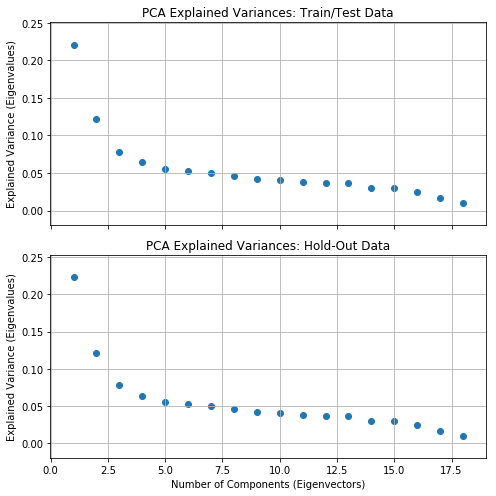

In [12]:
# Get the range of components
components = list(range(1, n_components+1))

# Display the Skree Plots to Compare the two Variance Distributions
show_skree_plots(components, variances)

### Train a Classification Model Using the RandomForestsClassifier 

In [13]:
%%time

# Train using the Training data.
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Make Predictions using the Test data.
y_pred = rfc.predict(X_test)
y_probs = rfc.predict_proba(X_test)

Wall time: 260 ms


#### Evaluate the Model's Efficacy using Metrics, a Confusion Matrix and Classification Report

----------------------------------------------------------------------------------
Accuracy (The Percentage of Correct Predictions): 0.761
----------------------------------------------------------------------------------
Null Accuracy (Achieved by Always Predicting the Most Frequent Class): 0.729
----------------------------------------------------------------------------------
True: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Pred: [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------

-------------------------------------------------------
Confusion Matrix
-------------------------------------------------------
Predictions    0    1
Actuals              
0            744   78
1            191  114
-------------------------------------------------------
Area Under the Curve (AUC): 0.764
-------------------------------------------------------

-------------------------------------------------------
Classification Report
------------------

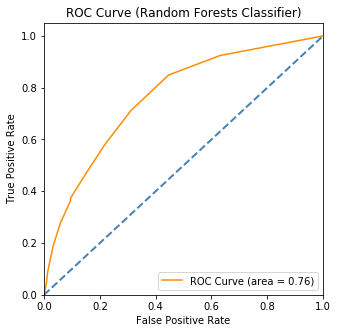

In [14]:
show_accuracy(y_test, y_pred, CLASSIFICATION_TYPE)
show_confusion_matrix(y_test, y_pred, y_probs, CLASSIFICATION_TYPE)
show_classification_report(y_test, y_pred)

if CLASSIFICATION_TYPE == 'Binary':
    show_roc_plot(y_test, y_probs, 'Random Forests Classifier')

#### Perform Hyperparameter Tuning for the Random Forests Classifier

In [15]:
%%time

# Define the parameter values to be searched
estimator_range = list(range(2, 21))
criterion_options = ['gini','entropy']
max_features_options = [None, 'auto','sqrt','log2']
max_depth_range = list(range(2, 21))

# Create parameter distributions
param_dist = dict(n_estimators = estimator_range
                  , max_features = max_features_options
                  , criterion = criterion_options
                  , max_depth = max_depth_range
                 )

# Instantiate the grid
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1) 
rand.return_train_score=False

# Finally, fit the grid
rand.fit(X_train, y_train)

Wall time: 18 s


In [16]:
# View the results
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.758154,0.011863,"{'n_estimators': 7, 'max_features': 'auto', 'm..."
1,0.758154,0.010716,"{'n_estimators': 4, 'max_features': None, 'max..."
2,0.769692,0.012995,"{'n_estimators': 11, 'max_features': 'log2', '..."
3,0.772798,0.007820,"{'n_estimators': 14, 'max_features': 'auto', '..."
4,0.762148,0.013032,"{'n_estimators': 6, 'max_features': 'sqrt', 'm..."
5,0.771023,0.015501,"{'n_estimators': 5, 'max_features': 'sqrt', 'm..."
6,0.782117,0.010076,"{'n_estimators': 12, 'max_features': None, 'ma..."
7,0.746838,0.013565,"{'n_estimators': 5, 'max_features': 'auto', 'm..."
8,0.785667,0.011275,"{'n_estimators': 9, 'max_features': 'auto', 'm..."
9,0.735523,0.000715,"{'n_estimators': 2, 'max_features': 'sqrt', 'm..."


In [17]:
dist_mean_scores = rand.cv_results_['mean_test_score']
param_estimators = rand.cv_results_['params']
items = list(range(0, len(param_estimators)))

estimators = []

for i in items:
    estimators.append(param_estimators[i]['n_estimators'])
    estimators.sort()
    
print('-------------------------------------------------------------------')    
print('Mean Test Scores:', dist_mean_scores)
print('-------------------------------------------------------------------')
print('Estimator Values:', estimators)
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Mean Test Scores: [0.75815398 0.75815398 0.76969159 0.77279787 0.76214777 0.77102285
 0.78211671 0.74683825 0.78566674 0.73552252]
-------------------------------------------------------------------
Estimator Values: [2, 4, 5, 5, 6, 7, 9, 11, 12, 14]
-------------------------------------------------------------------


Text(0,0.5,'Mean Test Scores')

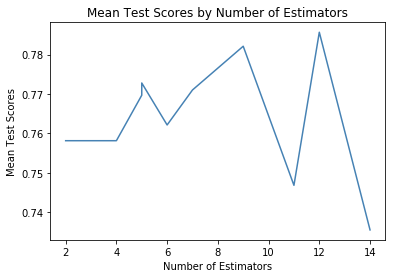

In [18]:
# Plot the scores
plt.title('Mean Test Scores by Number of Estimators')
plt.plot(estimators, dist_mean_scores, color='steelblue')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Scores')

In [19]:
# Examine the best score
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.7856667406256934
{'n_estimators': 9, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'gini'}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


#### Use the Best Parameters to Make Predictions Using the Hold-Out Data

In [20]:
%%time

n_estimators = rand.best_params_['n_estimators']
max_feature = rand.best_params_['max_features']
max_depth = rand.best_params_['max_depth']
criteria = rand.best_params_['criterion']

rfc = RandomForestClassifier(n_estimators = n_estimators
                             , max_features = max_feature
                             , criterion = criteria
                             , max_depth = max_depth
                             , random_state = 42
                            )
rfc.fit(X, y)

y_pred = rand.predict(X_eval)
y_probs = rand.predict_proba(X_eval)

Wall time: 238 ms


#### Evaluate the Model's Efficacy using Metrics, a Confusion Matrix and Classification Report

----------------------------------------------------------------------------------
Accuracy (The Percentage of Correct Predictions): 0.783
----------------------------------------------------------------------------------
Null Accuracy (Achieved by Always Predicting the Most Frequent Class): 0.735
----------------------------------------------------------------------------------
True: [1, 0, 0, 1, 0, 1, 0, 0, 1, 1]
Pred: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------

-------------------------------------------------------
Confusion Matrix
-------------------------------------------------------
Predictions    0    1
Actuals              
1            238  135
0            968   68
-------------------------------------------------------
Area Under the Curve (AUC): 0.819
-------------------------------------------------------

-------------------------------------------------------
Classification Report
------------------

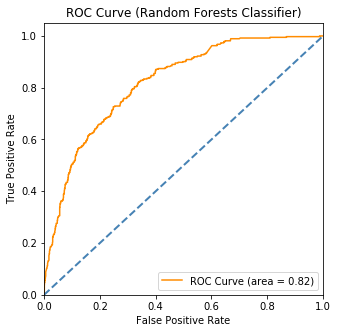

In [21]:
show_accuracy(y_eval, y_pred, CLASSIFICATION_TYPE)
show_confusion_matrix(y_eval, y_pred, y_probs, CLASSIFICATION_TYPE)
show_classification_report(y_eval, y_pred)

if CLASSIFICATION_TYPE == 'Binary':
    show_roc_plot(y_eval, y_probs, 'Random Forests Classifier')

#### Compare Model Accuracy Using K-Fold Cross-Validation

In [22]:
%%time

scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')

print('-------------------------------------------------------------------')
print("Accuracy Score per Fold: ", scores)
print('-------------------------------------------------------------------')
print("Average Accuracy Score: %0.3f" % scores.mean())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Accuracy Score per Fold:  [0.76595745 0.81028369 0.78014184 0.79964539 0.79432624 0.7712766
 0.78330373 0.79218472 0.77758007 0.77046263]
-------------------------------------------------------------------
Average Accuracy Score: 0.785
-------------------------------------------------------------------
Wall time: 1.91 s


### Train a Classifier Using K-Nearest Neighbors and K-Fold Cross-Validation

In [23]:
%%time

knn = KNeighborsClassifier()
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

print('-------------------------------------------------------------------')
print("Accuracy Score per Fold: ", scores)
print('-------------------------------------------------------------------')
print("Average Accuracy Score: %0.3f" % scores.mean())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Accuracy Score per Fold:  [0.75177305 0.7606383  0.75531915 0.7535461  0.75       0.75177305
 0.74777975 0.75843694 0.7366548  0.74911032]
-------------------------------------------------------------------
Average Accuracy Score: 0.752
-------------------------------------------------------------------
Wall time: 1.42 s


#### Perform Hyperparameter Tuning

In [24]:
%%time

# Define the parameter values to be searched
k_range = list(range(2, 26))
weight_options = ['uniform','distance']

# Create a parameter grid
param_grid = dict(n_neighbors=k_range, weights=weight_options)

# Instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, n_jobs=-1)

# Finally, fit the grid
grid.fit(X, y)

Wall time: 39.7 s


In [25]:
# View the results
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']].head()

,mean_test_score,std_test_score,params
0,0.744054,0.013930,"{'n_neighbors': 2, 'weights': 'uniform'}"
1,0.704118,0.015469,"{'n_neighbors': 2, 'weights': 'distance'}"
2,0.739794,0.012697,"{'n_neighbors': 3, 'weights': 'uniform'}"
3,0.731984,0.015990,"{'n_neighbors': 3, 'weights': 'distance'}"
4,0.760028,0.009250,"{'n_neighbors': 4, 'weights': 'uniform'}"


In [26]:
mean_test_scores = grid.cv_results_['mean_test_score']
params = grid.cv_results_['params']

items = list(range(0, len(params)))
weights = []

for i in items:
    weights.append(params[i]['weights'])

results = pd.DataFrame({'scores':mean_test_scores, 'weights':weights})      
uniform_scores = results[results.weights == 'uniform'].scores
distance_scores = results[results.weights == 'distance'].scores

print('----------------------------------------------------------------------------------')
print('Mean Test Scores (Uniform):', round(uniform_scores, 3).tolist())
print('----------------------------------------------------------------------------------')
print('Mean Test Scores (Distance):', round(distance_scores, 3).tolist())
print('----------------------------------------------------------------------------------')
print('K-Range Values:', k_range)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
Mean Test Scores (Uniform): [0.744, 0.74, 0.76, 0.752, 0.761, 0.759, 0.762, 0.76, 0.768, 0.765, 0.773, 0.767, 0.774, 0.772, 0.773, 0.769, 0.772, 0.771, 0.772, 0.771, 0.774, 0.772, 0.775, 0.771]
----------------------------------------------------------------------------------
Mean Test Scores (Distance): [0.704, 0.732, 0.733, 0.742, 0.741, 0.746, 0.742, 0.748, 0.752, 0.753, 0.753, 0.756, 0.755, 0.758, 0.759, 0.759, 0.758, 0.76, 0.76, 0.761, 0.76, 0.761, 0.76, 0.762]
----------------------------------------------------------------------------------
K-Range Values: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
----------------------------------------------------------------------------------


Text(0,0.5,'Cross-validated Accuracy')

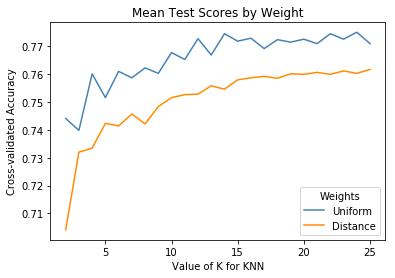

In [27]:
# Plot the scores
plt.title('Mean Test Scores by Weight')
plt.plot(k_range, uniform_scores, color='steelblue', label='Uniform')
plt.plot(k_range, distance_scores, color='darkorange', label='Distance')
plt.legend(loc='lower right', title='Weights')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated Accuracy')

In [28]:
# Examine the best score
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7749378771742989
{'n_neighbors': 24, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=24, p=2,
           weights='uniform')


#### Use the Best Parameters to Make Predictions Using Hold-Out Data

In [29]:
%%time

n_neighbors = grid.best_params_['n_neighbors']
weights_option = grid.best_params_['weights']

knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights_option)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

print('-------------------------------------------------------------------')
print("Accuracy Score per Fold: ", scores)
print('-------------------------------------------------------------------')
print("Average Accuracy Score: %0.3f" % scores.mean())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Accuracy Score per Fold:  [0.77304965 0.78546099 0.78014184 0.7748227  0.79787234 0.76595745
 0.76554174 0.76021314 0.78825623 0.75800712]
-------------------------------------------------------------------
Average Accuracy Score: 0.775
-------------------------------------------------------------------
Wall time: 1.39 s
